In [1]:
# https://arxiv.org/abs/1610.02415

# https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist

import torch_geometric
import torch_geometric.nn as gnn
#print(torch_geometric.__version__)
from torch_geometric.datasets import QM9
import GCL.augmentors
import GCL.augmentors as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression
import itertools


1.13.1+cu117


In [2]:

parameters = {}
parameters['batch_size'] = 64

In [3]:
whole_dataset = QM9(root = 'data/')

#print(whole_dataset.get_summary())
#print(dir(whole_dataset))
#print(whole_dataset.len())

n = whole_dataset.len()
tr_n = 2000 # Number of QM9 to use as training data

all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n)
print(len(tr_inds), len(val_inds))
print(type(tr_inds), type(tr_inds[0]))


train_sampler = torch.utils.data.SubsetRandomSampler(tr_inds)
val_sampler = torch.utils.data.SubsetRandomSampler(val_inds)

# We need to make a train and validation set since QM9 does not provide them
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = parameters['batch_size'],
                                                shuffle = True, num_workers = 2,)
                                                #sampler = train_sampler)
big_train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = int(1e9),
                                                shuffle = True, num_workers = 2,)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=2048,
                                            shuffle=False, num_workers=2,)
                                              #sampler = val_sampler)


2000 128831
<class 'list'> <class 'int'>


In [4]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capavity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C',}

print(qm9_index.items())

dict_items([(0, 'Dipole moment'), (1, 'Isotropic polarizability'), (2, 'Highest occupied molecular orbital energy'), (3, 'Lowest unoccupied molecular orbital energy'), (4, 'Gap between previous 2'), (5, 'Electronic spatial extent'), (6, 'Zero point vibrational energy'), (7, 'Internal energy at 0K'), (8, 'Internal energy at 298.15K'), (9, 'Enthalpy at 298.15K'), (10, 'Free energy at 298.15K'), (11, 'Heat capavity at 298.15K'), (12, 'Atomization energy at 0K'), (13, 'Atomization energy at 298.15K'), (14, 'Atomization enthalpy at 298.15K'), (15, 'Atomization free energy at 298.15K'), (16, 'Rotational constant A'), (17, 'Rotational constant B'), (18, 'Rotational constant C')])


In [31]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations
import GCL.augmentors as A
aug = A.RandomChoice([#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A.EdgeRemoving(pe=0.1)],
                     num_choices=1)

# From a set of augmentations of length n_augmentations
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling
aug_set = [node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
aug_strs = ['node_dropping', 'ppr_diffusion', 'feature_dropout', 'edge_adding', 'rw_sampling']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==2]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002
# etc parameters here which define model, hparams

for aug in aug_inds:

    tr_augs = []
    for ind, augi in enumerate(aug):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            
    print(str(tr_augs[0]).split(' ')[1], str(tr_augs[1]).split(' ')[1])
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    parameters['train_aug'] = tr_aug
    
    model, train_loss, val_loss = train_vicreg(parameters)
    transfer_scores = transfer_score(model, parameters)

['node_dropping', 'ppr_diffusion', 'feature_dropout', 'edge_adding', 'rw_sampling']
[(0, 0, 0, 1, 1), (0, 0, 1, 0, 1), (0, 0, 1, 1, 0), (0, 1, 0, 0, 1), (0, 1, 0, 1, 0), (0, 1, 1, 0, 0), (1, 0, 0, 0, 1), (1, 0, 0, 1, 0), (1, 0, 1, 0, 0), (1, 1, 0, 0, 0)]
'GCL.augmentors.edge_adding' 'GCL.augmentors.rw_sampling'
'GCL.augmentors.feature_dropout' 'GCL.augmentors.rw_sampling'
'GCL.augmentors.feature_dropout' 'GCL.augmentors.edge_adding'
'GCL.augmentors.ppr_diffusion' 'GCL.augmentors.rw_sampling'
'GCL.augmentors.ppr_diffusion' 'GCL.augmentors.edge_adding'
'GCL.augmentors.ppr_diffusion' 'GCL.augmentors.feature_dropout'
'GCL.augmentors.node_dropping' 'GCL.augmentors.rw_sampling'
'GCL.augmentors.node_dropping' 'GCL.augmentors.edge_adding'
'GCL.augmentors.node_dropping' 'GCL.augmentors.feature_dropout'
'GCL.augmentors.node_dropping' 'GCL.augmentors.ppr_diffusion'


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


epoch train loss 581.6645485162735


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


epoch train loss 78.25022399425507
epoch train loss 47.92624831199646
epoch train loss 36.82650303840637
epoch train loss 32.958508253097534
epoch train loss 30.538473308086395


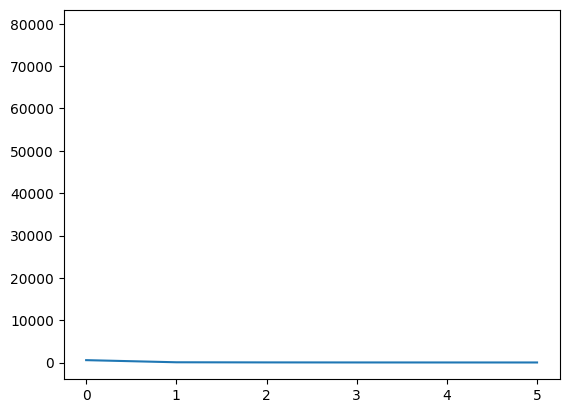

In [12]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        #self.mpool2 = gnn.global_mean_pool
        #self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        # Input graph to GConv
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        # GConv outputs projected to representation space
        #print('before pool: ', x.shape)
        x_rep = self.mpool1(x, binds)
        #print('pooled: ', x_rep.shape)
        
        #x_rep = self.fc1(x_rep)
        #print('projected: ', x_rep.shape, 'gconv', x.shape)
        
        x_emb = self.conv3(x, edge_index)
        #print('x emb after conv3', x_emb.shape)
        #x_emb = self.mpool2(x_emb, binds)
        #print('after pool', x_emb.shape)
        #x_emb = self.fc2(x_emb)
        #print('after fc2', x_emb.shape)
        
        return x_rep, x_emb

device = 'cuda'

model = GCN().to(device)

sim_coeff = 25
std_coeff = 25
cov_coeff = 1

aug = A.RandomChoice([#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A.EdgeRemoving(pe=0.1)],
                     num_choices=1)
val_aug = A.RandomChoice([], num_choices = 0)

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
transfer_mat = torch.zeros((len(qm9_index.keys()), 10))

n_epochs = 5
tr_losses = []
val_losses = []
for epoch in range(0,n_epochs+1):
    epoch_losses = []
    for batch in train_loader:
        optimizer.zero_grad()

        batch_inds = batch.batch.to(device)

        # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)

        batch.x = batch.x.float()#.to(device)
        #batch.edge_index = batch.edge_index.to(device)

        # Barlow - get 2 random views of batch
        b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
        b2 = aug(batch.x, batch.edge_index, batch.edge_attr)

        # Embed each batch (ignoring representations)
        r1, e1 = model(b1, batch_inds)
        r2, e2 = model(b2, batch_inds)

        loss = VicRegLoss(e1, e2)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.data.item())
        
    print('epoch train loss', sum(epoch_losses) / len(epoch_losses))
    tr_losses.append(sum(epoch_losses) / len(epoch_losses))
    
    if epoch % 10 == 0:
        
        # Downstream supervised loss
        for batch in big_train_loader: # take entire train set
            with torch.no_grad():
                # Embed training set under model
                rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))
                
                
                for val_batch in val_loader:
                    # Embed validation set under model
                    rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))
                    
                    # For each task in QM9
                    for tar_ind in range(batch.y.shape[1]):
                        # Fit a model on model representation of train set

                        #print(rep_tr.shape, batch.y[tar_ind].shap)
                        lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                        # Test the model on model repersentation of val set
                        tar_yhat = lm.predict(rep_val.cpu())
                        mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat)
                        r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                        #print(qm9_index[tar_ind], mse_met, r2_met)
                        transfer_mat[tar_ind, int((epoch-1)//10)] = r2_met
        
        # VicReg Validation Loss
        val_loss = []
        for batch in val_loader:
            with torch.no_grad():
                # VicReg validation loss
                b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
                b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
                r1, e1 = model(b1, batch.batch.to(device))
                r2, e2 = model(b2, batch.batch.to(device))
                
                val_loss.append(VicRegLoss(e1, e2).item())
                
        val_losses.append(torch.mean(torch.FloatTensor(val_loss)))

plt.plot(tr_losses)
plt.plot(val_losses)

tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,  -49.9331],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000, -212.5029],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000, -688.1343],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000, -237.6831],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,   -6.0872],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000, -497.0759],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000,  -52.9491],
        [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,   

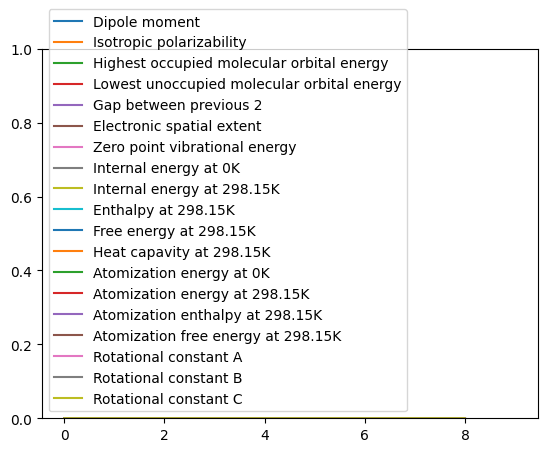

In [14]:
print(transfer_mat, transfer_mat.shape)
#print(breaker)
import matplotlib.pyplot as plt

for ind, row in enumerate(transfer_mat):
    plt.plot(row, label = qm9_index[ind])
    
plt.legend(loc = 'best')
plt.ylim(0,1)
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GCN().to(device)
#data = train_dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


aug = A.RandomChoice([#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A.EdgeRemoving(pe=0.1)],
                     num_choices=1)

val_aug = A.RandomChoice([], num_choices = 0)


def barlow(batch):
    # Return two random views of input batch
    return aug(batch[0], batch[1]), aug(batch[0], batch[1])

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class FullGatherLayer(torch.autograd.Function):
    """
    Gather tensors from all process and support backward propagation
    for the gradients across processes.
    """

    @staticmethod
    def forward(ctx, x):
        output = [torch.zeros_like(x) for _ in range(dist.get_world_size())]
        dist.all_gather(output, x)
        return tuple(output)

    @staticmethod
    def backward(ctx, *grads):
        all_gradients = torch.stack(grads)
        dist.all_reduce(all_gradients)
        return all_gradients[dist.get_rank()]
    
def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss

sim_coeff = 25
std_coeff = 25
cov_coeff = 1

model.train()
for epoch in range(5):
    
    epo_losses = []
    for batch in train_loader:
        #batch = batch.to(device)
        batch.x = batch.x.float()#.to(device)
        #batch.edge_index = batch.edge_index.to(device)

        optimizer.zero_grad()
        
        # Barlow - get 2 random views of batch
        b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
        b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
        
                
        # Embed each batch (ignoring representations)
        [r1, e1], [r2, e2] = model.pair_emb_rep(b1, b2)

        # VicReg loss on projections
        loss = VicRegLoss(e1, e2)
        
        loss.backward()
        optimizer.step()
        
        epo_losses.append(loss.data.item())
        
    print(sum(epo_losses) / len(epo_losses))
    
    ############################
    ## Per-epoch validation step:
    
    GCL.eval


    # Embed Training Samples:
    train_batch = next(iter(train_big_subset))
    #print('train batch', train_batch)
    train_batch = val_aug(train_batch.x, train_batch.edge_index, train_batch.edge_attr) # val_aug is an empty augmentation
    #print('train_batch augd', train_batch)

    with torch.no_grad():
        tr_rep, _ = model.forward(train_batch)
    #print(tr_rep.shape)

    # Train linear model on embedded samples:
    ridge_mod = RidgeClassifierCV(cv = 4).fit(tr_rep, y_train)
    linear_mod = LogisticRegression(penalty = None).fit(tr_rep, y_train)

    # Embed validation samples:
    val_batch = next(iter(val_loader))
    #print('val batch', val_batch)
    val_batch = val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr) # val_aug is an empty augmentation
    #print('val_batch augd', val_batch)
    
    with torch.no_grad():
        val_rep, _ = model.forward(val_batch)
    #print(val_rep.shape)

    # Test linear model on embedded samples:
    ridge_score = f1_score(ridge_mod.predict(val_rep), y_val)
    linear_score = f1_score(linear_mod.predict(val_rep), y_val)
    
    print(f'Classifier Scores at Epoch {epoch}:', round(linear_score, 3), round(ridge_score, 3))

In [ ]:
if False: # Update for some downstream? Keep in mind this idea of graph masking
    # Evaluate
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')